<div style="background-color:#009440; padding: 0px; background-size:cover; background-opacity:50%; border-radius:5px; height:300px">
    <div style="margin: 5px; padding: 10px;">
    <h1 style="color:#00000">Geophysical Data Acquisition and Analysis</h1>
    <h5 style="color:#C0C0C0">LMU, summer 2016</h5>
    <h4 style="color:rgba(0,0,0,0.6)">Stefanie Donner, Céline Hadziioannou, Ceri Nunn</h4>
    </div>
    <div style="float:right; margin: 20px; padding: 20px; background:rgba(255,255,255,0.7); width: 70%; height: 100px">
        <div style="position:relative; top:40%; transform: translateY(-50%)">
        <div style="font-size: x-large; font-weight:900; color:rgba(0,0,0,0.8); line-height:100%">P2.4 - Final exam report</div>
        </div>
    </div>
   
</div>

## Rules + deadline

In the following you find five exercises plus some basic code. Adapt the code as needed to answer the questions and provide your answers in separate markdown cells below the exercise. Please, do not forget to label axes, lines, titles, etc in your plots.  
Make sure that your answers are as elaborate and detailed as necessary to make your answer clear. However, concentrate on the essentials. 

In case you refer to literature/sources outside the course material, do not forget to acknowledge or cite them properly. You are also allowed to include images from outside the notebook if that may help you to explain. In that case, do not forget to provide us with the image files then. This is how you import figures in markdown: 

`<img style="float: left; height: 350px; padding: 10px" src="DATA/figure.jpg"/>`

For help with coding, please, consult the official [Python](http://docs.python.org/) and [ObsPy](http://docs.obspy.org) documentation. For help in formating the markdown cells, you can find help e.g. at the webpage of [wikipedia](https://en.wikipedia.org/wiki/Markdown) or on the [cheat sheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet). In case of severe problems, please contact us in time.

Submit your final notebook via mail to Stefanie Donner (donner@geophysik.uni-muenchen.de) at the latest 

### August 5th, 23:55 !!!

Notebooks received after that time will not be considered.

*Please, do not forget to execute Cell 0 first!*

<br>
<br>

In [1]:
# Cell 0: Preparation for programming
%pylab inline
from __future__ import print_function
from scipy import interpolate, signal
from time import *
from obspy import *
from obspy.core import read, UTCDateTime
from obspy.clients.fdsn import Client
from obspy.signal.cross_correlation import xcorr_pick_correction
import numpy as np
import matplotlib.pylab as plt
import os
import glob
import wave
import struct
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['lines.linewidth'] = 1

Populating the interactive namespace from numpy and matplotlib


______________

## Exercise 1

In this exercise you will work on broadband data from the Mw8.2 Chile earthquake from 1st of April 2014 at 23:46:47 UTC recorded at the black forest station in SW Germany (BFO). The goal of this exercise is to show your understanding of the principal basics in signal processing. Answer the following questions and perform the necessary steps in the corresponding code cells.

a) In cell 1a you fetch the waveforms via the FDSN client of IRIS and remove the instrument characteristic of the data (no further coding necessary here). Explain what "removing the instrument response" means and why it is necessary. Which mathematical method do you connect with this step? What is to consider during instrument response removal? A hint is given by the options used for removing the instrument response. Comment on all of them.

b) Now that you have downloaded the data and removed the instrument response, which further steps do you need to perform for pre-processing? Assume that for your scientific task the highest frequency you want to analyse is 5Hz. Describe the general pre-processing chain and point out the possible pitfalls and how to avoid them. Among others, some steps are high-pass filtering and demean as well as detrend the trace. Why do you do so?

c) Bonus _(Optional, for extra points)_: Try to plot the ray paths for this special earthquake receiver pair. Identify which phases should be theoretically visible in the seismogram. Try to identify them. 

3 Trace(s) in Stream:
II.BFO.00.BHE | 2014-04-01T23:30:00.019500Z - 2014-04-02T02:29:59.969500Z | 20.0 Hz, 216000 samples
II.BFO.00.BHN | 2014-04-01T23:30:00.019500Z - 2014-04-02T02:29:59.969500Z | 20.0 Hz, 216000 samples
II.BFO.00.BHZ | 2014-04-01T23:30:00.019500Z - 2014-04-02T02:29:59.969500Z | 20.0 Hz, 216000 samples


II.BFO.00.BHZ | 2014-04-01T23:30:00.019500Z - 2014-04-02T02:29:59.969500Z | 20.0 Hz, 216000 samples

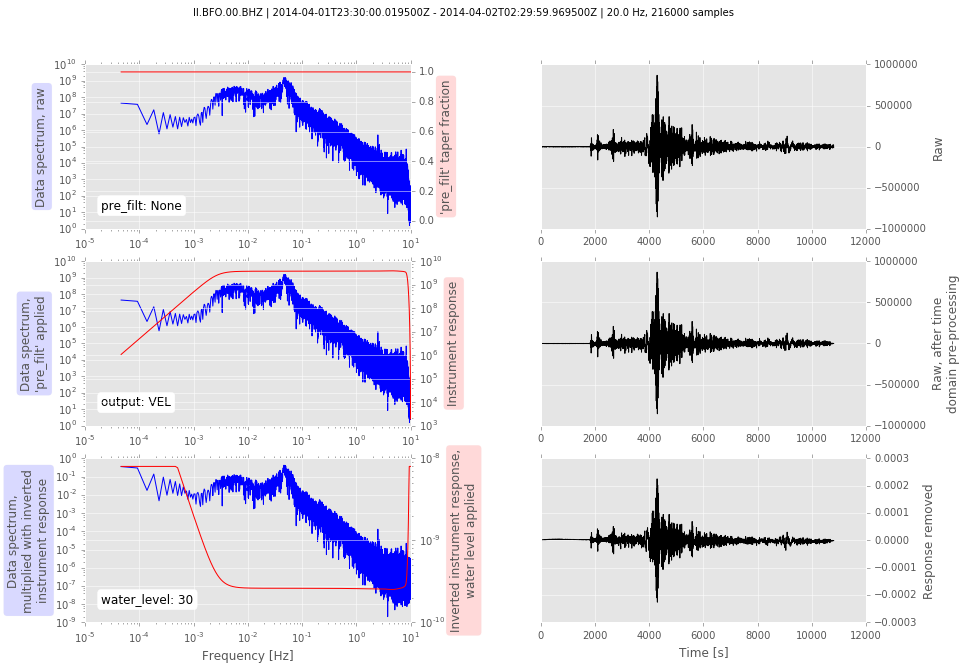

In [2]:
# Cell 1a : getting the waveforms

client = Client("IRIS")
t = UTCDateTime("2014-04-01T23:30:0.0")

st = client.get_waveforms("II", "BFO", "*", "BH?", t, t+(180*60), attach_response=True)
print(st)
st[0].remove_response(output="VEL", pre_filt=None, water_level=30, zero_mean=True, taper=True, taper_fraction=0.05, 
                   plot=False)
st[1].remove_response(output="VEL", pre_filt=None, water_level=30, zero_mean=True, taper=True, taper_fraction=0.05, 
                   plot=False)
st[2].remove_response(output="VEL", pre_filt=None, water_level=30, zero_mean=True, taper=True, taper_fraction=0.05, 
                   plot=True)

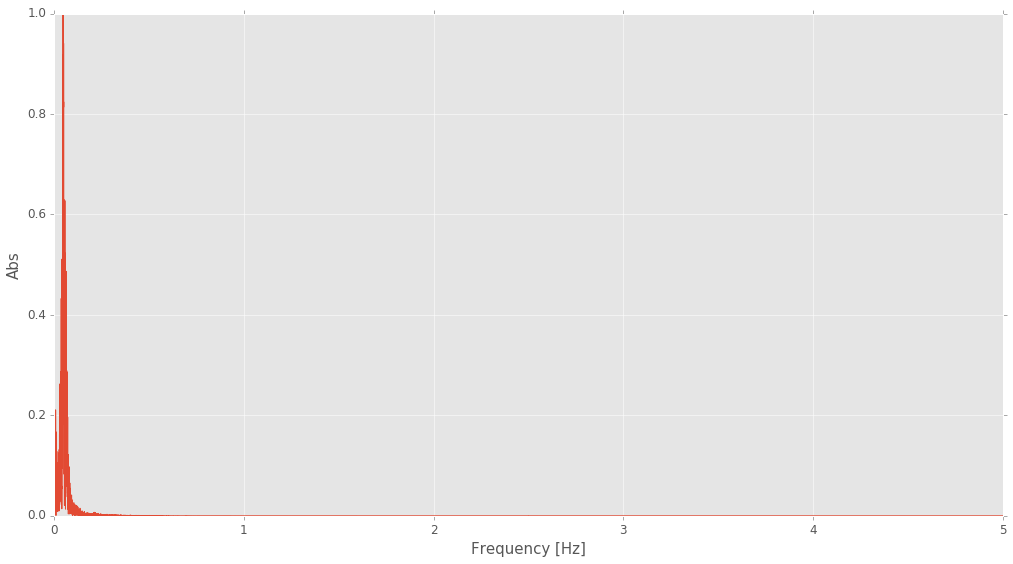

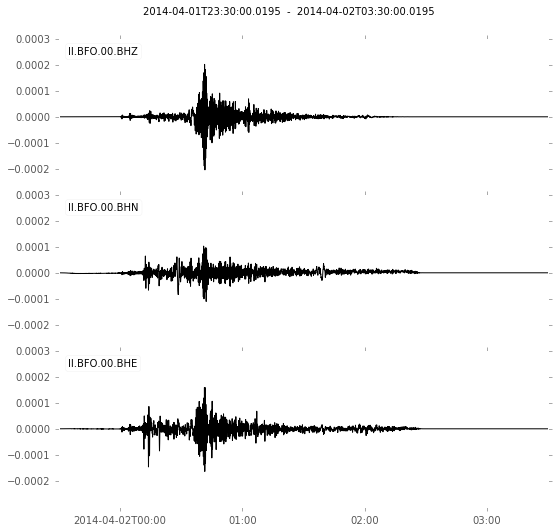

In [3]:
# Cell 1b: pre-processing the data

# take a copy of the stream to avoid overwriting the original data
bfo = st.copy()
tr = bfo[2]

# pre-processing
df = tr.stats.sampling_rate
npts = tr.stats.npts
tr.data = tr.data.astype('float64') # convert to double
tr.data = detrend(tr.data, 'linear') # de-trend

# apply windowing function to ensure the real waveform data- 
# starts and ends at zero
tr.data *= np.hanning(npts) # window

# define the total length of the record 
n = int(len(tr.data)*1.0)

# do the fourier transform
fdat = np.fft.rfft(tr.data, n=n)

# take the first 5 Hz only
N = len(fdat) * 0.5
N = int(N)
freq = np.linspace(0, df/2, len(fdat))
freq = freq[1:N+1] # zero frequency is offset
fdat = fdat[1:N+1]
fdat /= abs(fdat).max() # normalize to 1

# plot the results
from matplotlib import rcParams
rcParams["figure.subplot.hspace"] = (0.4)
rcParams["figure.figsize"] = (17, 9)
rcParams["axes.labelsize"] = (15)
rcParams["axes.titlesize"] = (20)
rcParams["font.size"] = (12)

plt.figure()
plt.plot(freq, abs(fdat))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Abs')
plt.show()

# in time domain we have:
trc = bfo
bfo.detrend() # detrend
bfo.taper(max_percentage = 0.05) # apply taper
bfo.filter("lowpass", freq = 5.0) # apply lowpass 5Hz
bfo.trim(t,t+(240*60),pad = True, fill_value = 0) # trim for zero padding
bfo.plot()

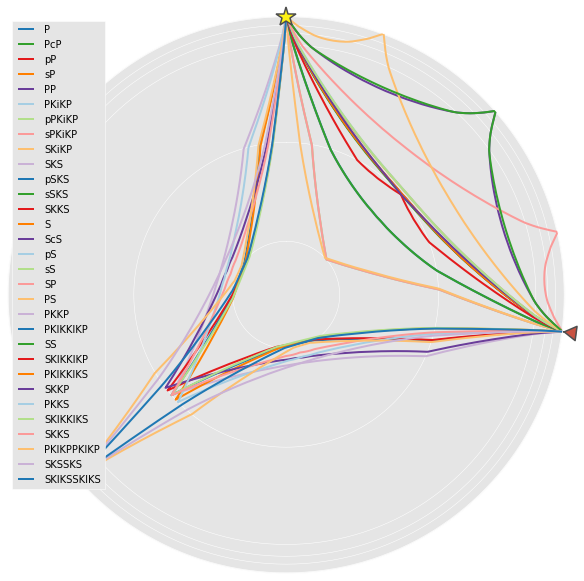

In [4]:
# Cell 1c - part 1: plot of ray pathes for this EQ-receiver pair

# loading the necessary package as a hint ...
from obspy.taup import TauPyModel

model = TauPyModel(model='prem')

# Ray pathes for Chile EQ-receiver 
# we can get information about earthquake depth and distance between EQ and BFO
# from IRIS Welber 3 webpage: "http://ds.iris.edu/wilber3/find_event"
arrivals = model.get_ray_paths(source_depth_in_km=25, distance_in_degree=97.60)
arrivals.plot(plot_type='spherical', legend=True, label_arrivals=False)

In [5]:
# Cell 1c - part 2: plot seismogram with theoretical travel times

# loading the necessary package as a hint ...
from matplotlib.pyplot import cm
from obspy.taup.taup import travelTimePlot

travelTimePlot(min_degree=0, max_degree=100, depth=25, model='prem')

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: ObsPyDeprecationWarning: The travelTimePlot() function is deprecated. Please use the obspy.taup.TauPyModel class directly.


KeyboardInterrupt: 

### Answer to exercise 1

...
a) Removing Instrumemnt Response :

The signal u(t) is a convolution of the seismic source, the earth structure, and the recording system. Most seismological studies focus on either the earth structure or the seismic source and thus deconvolving the instrument response is a common step to convert the recorded trace into meaningful ground motion. The instrumentation introduces distortion, and scaling of the data and therefore must be removed from the raw data. Removing the instrument response separates the effects of the instrumement on the gound motion, and additional filtering can be done afterwads which depends on the specific questions to be answered.

Mathematically, we use Deconvolution to remove the effects of the instrument response. Deconcolution is the inverse of convolution operator. Deconvolution is usually performed by computing the Fourier Transform of the recorded signal h and the transfer function g, apply deconvolution in the Frequency domain, which in the case of absence of noise is F=H/G
F, G, and H being the Fourier Transforms of f, g, and h. Finally, we inverse Fourier Transform F to find the estimated deconvolved signal f. 

Since deconvolution involves division, we need to be careful about diving by zero which can cause the output to blow up. This is usually averted by setting a water level where any values below a certain level in the instrument response are clipped and replaced with the water level and so the convolution becomes safe to perform. An alternative method is to taper the data in the frequency domain before dividing it by the instrument response, it is basically filtering the data before removing the instrument response

Options used :

pre_filt : we could pre filter the data before removing the instrument response, however in this code we do not perform it.

water_level : we define the water level below which the data will be clipped to avert exploding our waveform data, in this code it was defined as 30

zero_mean :  it was defined as true in the code, which subtracts the mean of the waveform data is in time domain before performing deconvolution.

taper : it was defined as true in the code, which applies a cosine taper to the waveform data in the time domain prior to deconvolution, this deminishes the gibbs fenomenon which is a product of performing the fourier transform.

taper_fraction : we define the taper fraction of the cosine taper to be used, it was defined as 0.05 in this code.

plot : it was defined as true in the code, which plots an illustration on how the data is processed in the frequency domain in three steps.


Q. 1 b) Steps for Pre Processing:

1. We start with filtering the analog data to avoid aliasing. This is done by chosing a sampling frequency that is greater than the nyquist frequency - minimum sampling frequency which would avoid aliasing, it is double the frequency of the data to be sampled. 

2. Then we can remove the instrument respnse by deconvolution.

3. Windowing :  choosing the appropriate window length in the time domain, for the event we want to look at, and remove the other data which is not of interest to us, which saves time, memory and computational costs. We could window in the frequency domain also using high pass, low pass or band pass filters. 

4. Demean and Detrend:  Demeaning refers to subtracting the mean value from the data which helps to get rid off possible offset values. Detrend removes any possible global trend  which leaves the local effects of short time scale in our chosen time window. This is done by removing the best fitting line from the global data set.

5. Tapering : We can also taper to smooth the ends of the record to avoid Gibbs phenomenon due to abrupt discontinuities.  The Fourier Transform should be performed on a continuous function, however if a data set has discontinuities then the Gibbs Phenomenon occures at these discontinuities. To avoid this we apply a taper to our data which would smooth out the discontinuities.

6. Zero Padding : Zero padding does not add anything to frequency spectrum, but increases frequncy resolution by increasing the length of the signal. Then we can perform any spectral analysis depending on the task at hand. If we are looking at high frequency signals, we use a high pass filter to remove the low frequency components from our signal (tides might be a possible source for these low frequency signals which we wish to remove).


Q. 1 c) P and S waves should be visible in the seismogram since the seismic station is 97.6 degrees.

_____________
## Exercise 2 : Marienplatz Glockenspiel - spectral analysis

In the very top of the tower of the New Town Hall (Rathaus) on Marienplatz, there are 43 bells, which chime different tunes daily at 11am and 12am. The tunes accompany a spectacle of figurines that move and illustrate local stories.  
In this exercise, we will analyze a recording of the Glockenspiel bells. 

You can read more about the Glockenspiel here: https://en.wikipedia.org/wiki/Rathaus-Glockenspiel

You can listen to the first tune of the Glockenspiel recording by playing `data/Glockenspiel_Marienplatz_track1.wav`  


---

<img style="float: left; height: 350px; padding: 10px" src="data/rathaus_munchen.jpg"  />
<img style="float: right; height: 350px; padding: 10px" src="data/glockenspiel_inside.jpg"  />


###### Acknowledgement
_photo Rathaus (left): _ https://commons.wikimedia.org/wiki/File:Altes_Rathaus_und_Mariens%C3%A4ule_in_M%C3%BCnchen.jpg  
_photo inside Glockenspiel (right): Thies Heidecke_  
_We are grateful to the personnell at the Rathaus for providing access to the Glockenspiel tower._  
_We thank Thies Heidecke for his help with the recording. _

In [6]:
# Cell 2a-1 - Read in the .wav file

# read in the file 
dataDir = './data/'
fileName = 'Glockenspiel_Marienplatz_track1.wav'
# if your computer cannot handle the complete tune, use this file instead (only first 15 seconds)
#fileName = 'Glockenspiel_Marienplatz_track1_short.wav'

stream = wave.open(dataDir + fileName,'r')

# get the details about the .wav file
num_channels = stream.getnchannels()
frame_rate = stream.getframerate()     # sampling rate
sample_width = stream.getsampwidth()   
num_frames = stream.getnframes()      # number of points
total_samples = num_frames * num_channels
endtime = float(total_samples) / float(frame_rate)

# read the byte data
raw_data = stream.readframes( num_frames )
stream.close()

# check the type of audio track
if sample_width == 1: 
    fmt = "%iB" % total_samples # read unsigned chars
elif sample_width == 2:
    fmt = "%ih" % total_samples # read signed 2 byte shorts
else:
    raise ValueError("Only supports 8 and 16 bit audio formats.")

# unpack the byte data to integers
integer_data = struct.unpack(fmt, raw_data)

# Keep memory tidy
del raw_data

# set up the channel
channels = [ [] for time in range(num_channels) ]

# read the integers to channels
for index, value in enumerate(integer_data):
    bucket = index % num_channels    
    channels[bucket].append(value)
    
# signal and timeseries arrays:
gsignal = channels[0]
time = np.linspace(0,endtime,total_samples)  # in seconds

print('Number of samples in the signal:', len(gsignal))   

Number of samples in the signal: 3969000


1 Trace(s) in Stream:
... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:01:29.999977Z | 44100.0 Hz, 3969000 samples


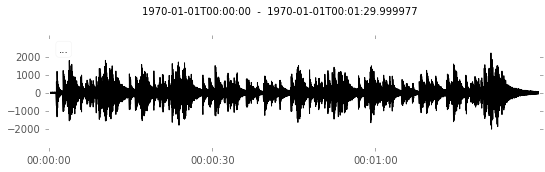

In [7]:
# Cell 2a-2 - read .wav into obspy Stream object

st = read(dataDir + fileName)
print(st)
st.plot()

# just the signal array and time vector
gsignal_st = st[0].data
time_st = st[0].times()

In the previous two cells, the glockenspiel tune has been read in two different ways:

+ `gsignal` is a numpy array with the signal values. Associated time vector is 'time'; sampling rate is in the variables 'frame_rate'
+ `st` is an obspy stream object with the same glockenspiel tune. You can manipulate it in the same way as other stream objects in previous practicals. 

Both contain the same signal, so you can use whichever one is easiest in the following exercise. 

### Questions - part 1

**Note:** if the signal is too large for your computer to handle, use the alternative, shorter signal which contains only the first 15 seconds of the tune. See Cell 2a, where the filename is defined. 

Create several subplots: plot the signal on top, and below that create two subplots: in the first, plot the spectrogram using a window length of 256 samples. 
In the second, plot the spectrogram with a window length of 4096 samples. In both, use an overlap of 50. 

a) Explain what a spectrogram (in general) represents. Through which mathematical operation is the y-axis (frequency axis) created? What controls the value of the upper limit of the y-axis?

b) Compare the spectrograms with `NFFT=256` and `NFFT=4096`. What difference between the two do you notice? Think in terms of time and frequency resolution. Explain why this happens.  
Remember you can zoom in to specific parts of the signal by manipulating the plot limits 
(`plt.xlim((value1, value2))` or `plt.ylim((value1, value2))`) 

c) On both spectrograms, zoom in to frequency around 6780 Hz using `plt.ylim((value1, value2))` . This frequency corresponds to one of the bells. Isolate the signal of this bell as much as you can using a filter.  
Go to Cell 2c. In a new plot, plot the original (unfiltered) signal and the filtered signal on top of each other with different colors. How often does the 6780Hz bell ring in the first 10 seconds of the song? (You may want to trim the signal to the first 10 seconds first). 

d) If you plot a spectrogram of the filtered signal, you will see that the energy of the signal outside your filter band is not exactly zero. What is this effect called?  
Explain how you could achieve a narrower filter (you do not need to execute it for this signal, just describe). What kind of tradeoff will you encounter as you use a narrower filter window? 



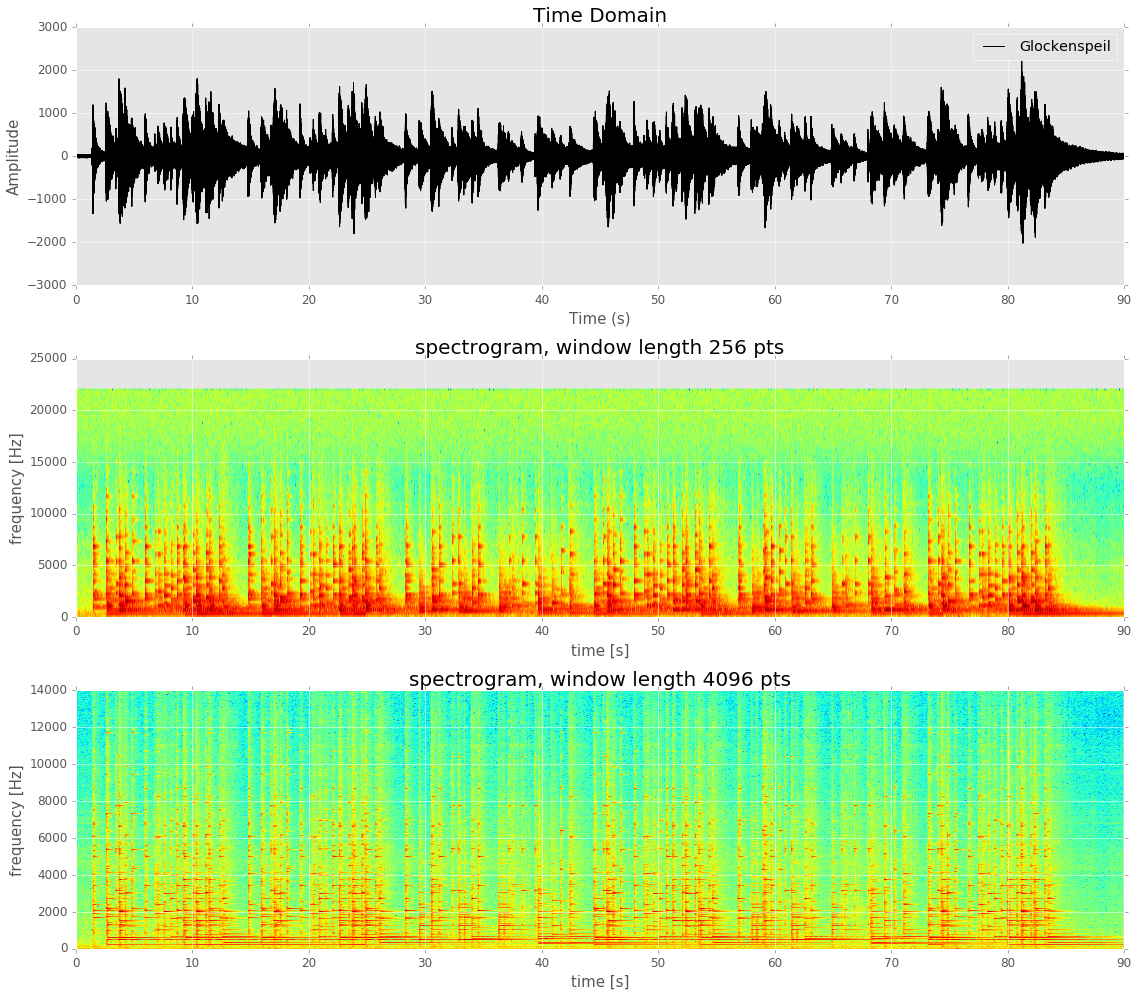

In [11]:
# Cell 2b - compare spectograms

# first and second spectrogram window:
NFFT = 256
NFFT2 = 4096
# number of sample points that the sliding window overlaps
noverlap = 50
noverlap2 = 50

# range of the x axis 
xstart = 0
xend = 90

# maximum and minimum frequency for the plot in Hz
plot_freq_min = 0 
plot_freq_max = 14000 

# make a time series in seconds
time = np.linspace(0,endtime,total_samples)  
plt.figure(figsize=(16,14))
ax1 = plt.subplot(311)
plt.plot(time, channels[0], 'k', label="Glockenspeil", lw=1)


plt.plot(time, channels[0], 'k', lw=1)
plt.legend()
plt.title('Time Domain')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# plt.ylim((plot_freq_min, plot_freq_max))
plt.subplot(312, sharex=ax1)
plt.title('spectrogram, window length %s pts' % NFFT)

Pxx, freqs, bins, im = plt.specgram(channels[0], NFFT=NFFT, Fs=frame_rate, noverlap=noverlap,
                                cmap=cm.jet,sides='onesided')


plt.ylabel('frequency [Hz]')
plt.xlabel('time [s]')
#plt.ylim(plot_freq_min,plot_freq_max)

plt.subplot(313, sharex=ax1)
plt.title('spectrogram, window length %s pts' % NFFT2)

Pxx, freqs, bins, im = plt.specgram(channels[0], NFFT=NFFT2, Fs=frame_rate, noverlap=noverlap2,
                                cmap=cm.jet,sides='onesided')
plt.ylim((plot_freq_min, plot_freq_max))
plt.ylabel('frequency [Hz]')
plt.xlabel('time [s]')
plt.xlim((xstart, xend))
#plt.ylim(plot_freq_min,plot_freq_max)

# prevent subplots overlapping
plt.tight_layout() 

plt.show()





### Answer to exercise 2 - part 1/1

a) A spectrogram is a plot of time vs frequency. It is a visual representation of the spectrum of frequencies and their strengths in a  signal as they vary with time or some other variable. Mathematically the spectrogram of a certain signal can be calculated by obtaining the squared magnitude of the short-time fourier transform of said signal.

The Y axis is created by Fourier Transform. The nyquist frequency sets the limit of the maxima of the y axis. We can see that for window length of 256 the y axis has a higher maxima than for a window length of 4096.

b) On comparing we see that the one with the window lenght as 256, the individuals notes are sharper but the frequency resolution is not good . However for the window length of 4096, you can see that the individual notes are less easily visible, but the harmonics of the Glockenspeil are much sharper. This happens due to the uncertainty principle in time and frequency domains.

One can also relate it to, Δf = 1/NΔT. Therefore increasing N will reduce Δf, thus making the frequency resolution finer.

(0, 10)

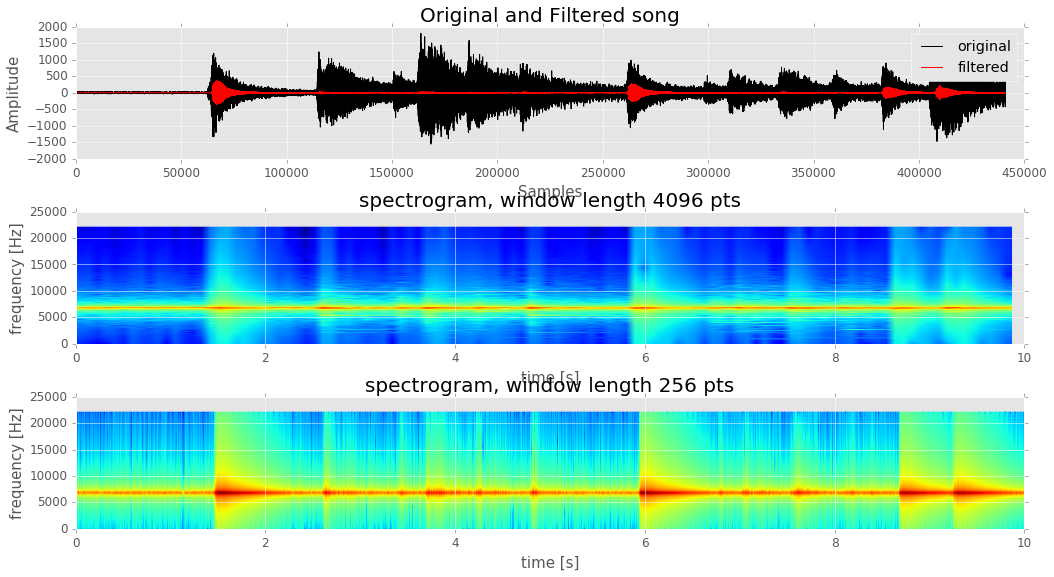

In [13]:
# Cell 2c - isolate single bell
f_bell = 6780
stf = st.copy()

# bandpass filtering 
stf.filter('bandpass', freqmin=f_bell-50, freqmax=f_bell+50) 

# triming the signals
st.trim(starttime=st[0].stats.starttime,endtime=UTCDateTime("1970-01-01T00:00:10.000000Z")) 
stf.trim(starttime=st[0].stats.starttime,endtime=UTCDateTime("1970-01-01T00:00:10.000000Z"))
plt.subplot(311)
plt.plot(st[0],'k',label='original',zorder=1)
plt.plot(stf[0],'r',label='filtered',zorder=2)
plt.title('Original and Filtered song')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()


# the spectrogram of the filtered signal


plt.subplot(312)
Pxx, freqs, bins, im = plt.specgram(stf[0], NFFT=NFFT2, Fs=frame_rate, noverlap=noverlap2,
                                 cmap=cm.jet,sides='onesided')
plt.title('spectrogram, window length %s pts' % NFFT2)
plt.ylabel('frequency [Hz]')
plt.xlabel('time [s]')
plt.xlim((0, 10))

plt.subplot(313)
Pxx, freqs, bins, im = plt.specgram(stf[0], NFFT=NFFT, Fs=frame_rate, noverlap=noverlap2,
                                 cmap=cm.jet,sides='onesided')
plt.title('spectrogram, window length %s pts' % NFFT)
plt.ylabel('frequency [Hz]')
plt.xlabel('time [s]')
plt.xlim((0, 10))






### Answer to exercise 2 - part 1/2

a) The bell rings 4 times in the first 10 seconds of the spectrum.


b) This effect is called spectral leakage, the effect of which can be reduced by changing the window function. Spectral leakage happens whenever we introduce components into the frequency spectrum of a signal and also as a result of finite length of the signal. This adds energy components outside the filter band.
By widening the time window we can narrow the filter, in accordance with the uncertainty principle. There is a tradeoff between the resolution in the frequency domain and resolution in the time domain. Using a narrower filter increases the spectral leakage.


### Questions - part 2

In the following Cell 2d, we consider part of the spectral content of a single bell chime. The spectrum is calculated for several different lengths of time window:  
1. the complete bell chime (approx. 0.8 seconds)
2. a short time window (500 samples)
3. a longer time window (3000 samples)
4. the longer time window, with the rest of the signal set to zero (so 3000 samples + zero padding to complete signal length) (**Note:** in the first plot, the blue signal is offset downwards by 500 points. This is just to make the difference between green and blue line more visible. ) 

Explain the difference between the spectra obtained with the different time window lengths. 
In particular, consider why the peak around f=3750Hz does not show up when using the shortest time window (red line). Why is the blue spectrum smoother than the green one? 



1 Trace(s) in Stream:
... | 1970-01-01T00:00:09.100000Z - 1970-01-01T00:00:09.900000Z | 44100.0 Hz, 35281 samples


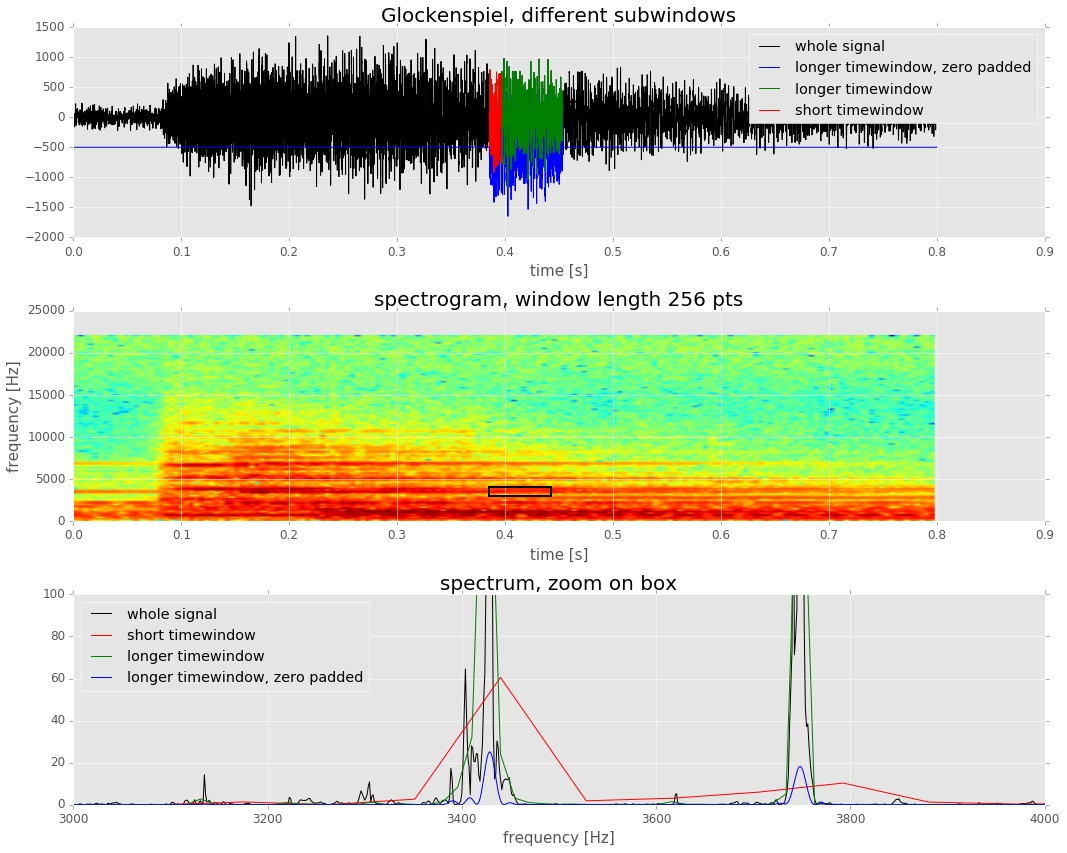

In [14]:
# Cell 2d - single bell chime

NFFT = 256

# time limits to trim signal to, in seconds 
ts1 = st[0].stats.starttime + 9.1
ts2 = ts1 + 0.8

# subwindow lengths, in samples
lwin1 = 500
lwin2 = 3000

# time limits for subwindow in signal, in samples
lim1 = 17000
lim2 = lim1 + lwin1
lim3 = lim1 + lwin2

stsh = st.copy()
stsh.trim(ts1, ts2)
print(stsh)

stz = st.copy()
stz.trim(ts1, ts2)
# set signal outside subwindow to zero
stz[0].data[0:lim1] = 0
stz[0].data[lim3:] = 0

# calculate spectrum for different window lengths:
# whole signal (black)
f, Pxx_den = signal.periodogram(stsh[0].data, stsh[0].stats.sampling_rate)
# short timew window (red)
f2, Pxx_den2 = signal.periodogram(stsh[0].data[lim1:lim2], stsh[0].stats.sampling_rate)
# longer time window (green)
f3, Pxx_den3 = signal.periodogram(stz[0].data[lim1:lim3], stz[0].stats.sampling_rate)
# longer time window, with zero padding around it (blue)
f4, Pxx_den4 = signal.periodogram(stz[0].data, stz[0].stats.sampling_rate)

# plot signal, spectrogram and spectrum (zoomed in to 2 peaks, as indicated by black box in spectrogram)
plt.figure(figsize=(15,12))

# time series
ax1 = plt.subplot(311)
plt.plot(stsh[0].times(), stsh[0].data, 'k', label='whole signal')
plt.plot(stz[0].times(), stz[0].data - 500, 'b', label='longer timewindow, zero padded')
plt.plot(stz[0].times()[lim1:lim3], stz[0].data[lim1:lim3], 'g', label='longer timewindow')
plt.plot(stsh[0].times()[lim1:lim2], stsh[0].data[lim1:lim2], 'r', label='short timewindow')
plt.legend()
plt.xlabel('time [s]')
plt.title('Glockenspiel, different subwindows')

plt.subplot(312, sharex=ax1)
plt.title('spectrogram, window length %s pts' % NFFT)
# Pxx is the segments x freqs array of instantaneous power, freqs is
# the frequency vector, bins are the centers of the time bins in which
# the power is computed, and im is the matplotlib.image.AxesImage instance
Pxx, freqs, bins, im = plt.specgram(stsh[0].data, NFFT=NFFT, Fs=frame_rate, noverlap=noverlap,
                                cmap=cm.jet,sides='onesided')
#draw box
plt.plot((lim1/frame_rate, (lim2+2000)/frame_rate), (3000, 3000), 'k-', lw=2)
plt.plot((lim1/frame_rate, (lim2+2000)/frame_rate), (4000, 4000), 'k-', lw=2)
plt.plot((lim1/frame_rate, lim1/frame_rate), (3000, 4000), 'k-', lw=2)
plt.plot(((lim2+2000)/frame_rate, (lim2+2000)/frame_rate), (3000, 4000), 'k-', lw=2)

#plt.ylim((0,5000))
plt.ylabel('frequency [Hz]')
plt.xlabel('time [s]')

# show spectra calculated with different timewindows
plt.subplot(313)
plt.plot(f, Pxx_den, 'k', label='whole signal')
plt.plot(f2, Pxx_den2, 'r', label='short timewindow')
plt.plot(f3, Pxx_den3, 'g', label='longer timewindow')
plt.plot(f4, Pxx_den4, 'b', label='longer timewindow, zero padded')
plt.legend(loc='upper left')
plt.xlabel('frequency [Hz]')
plt.title("spectrum, zoom on box")
plt.xlim((3000,4000))
plt.ylim((0,100))
# prevent subplots overlapping
plt.tight_layout() 
plt.show()

### Answer to exercise 2 - part 2

In the short time window we get good resolution of the time while getting bad resolution of the frequencies, in the long time window we get bad resolution of the time while getting good resolution of the frequencies. This is due to the uncertainty principle, we can either have high precision of the frequency or high precision of the time but not in both, they are inversely proportional.
We can see that  Δf = 1/NΔT.
Therefore for a short time window with smaller N (500), the Δf is much larger than in the case of the green one with larger N(3000).For the red spectrum, N is the smallest, therefore its Δf is the largest. The green represents a long time window and the blue is a long time window and padded with zeros which has even a finer Δf

The red line shows that with good time resolution we have a lot of energy stored within a short time interval, this leads to the smearing of the frequencies in the short time window. This is why we cannot identify the sharp peaks of frequencies using the red line, only a broad range of frequencies can be identified. These peaks can be determined using the long time windows (blue and green lines), this phenomenon is due to the uncertainty principle

The blue one is padded and has a smaller Δf than the green. Therefore the spctrum  for the green one has larger step size than the blue. Thus the blue spectrum is made of more points and is smoother than the green one.



_______________________

## Exercise 3

This question is about convolution of signals. You are provided with two signals. 

a) What is a convolution? Convolution is closely connected to a special kind of system. Which one? Describe the connection. <br> 
Using [signal.convolve](http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html) convolve the two signals in Cell 3a. Set the mode='same'. Explain the meaning of the mode parameter. <br>
Plot the original signals and the convolved signal. Be careful to plot the entire signal on both the x and y axes. Include labels.  

b) In cell 3b, replace one of signals with a new signal that has a different shape. Convolve the signals and plot them again. Are convolutions commutative? 

c) In cell 3c, convolve the signals win and sig in the reverse order, continuing to use mode='same'. Replot. <br>
Are the results the same or different from cell 2a? Explain this result. Explain any inconsistencies.

d) Bonus _(optional for extra points)_: Amend the signals so that convolving them in the reverse order gives the same result as convolving them in original order. 

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


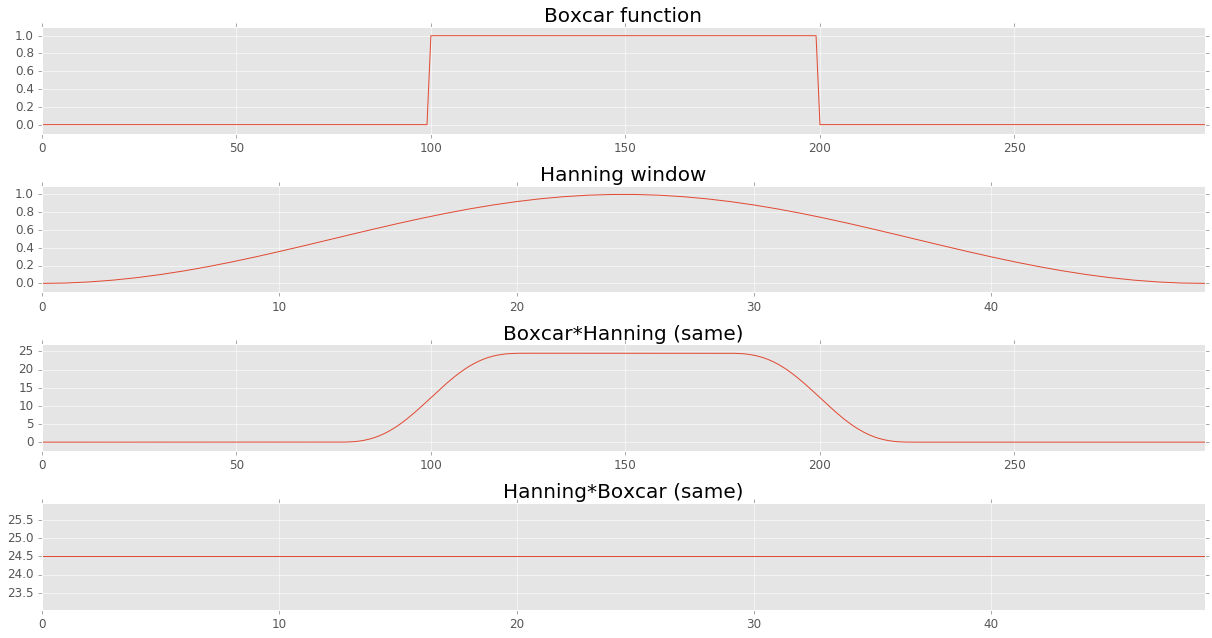

In [16]:
#Cell 3a - convolving two signals + plotting

# make a box car function
box = np.repeat([0., 1., 0.], 100)
# make a Hann window 
win = signal.hann(50)

# convolve the signals
filtered = signal.convolve(box, win, mode='same') 
filtered_2 = signal.convolve(win, box, mode='same') 
fig, (ax_orig, ax_win, ax_filt,ax_filt_2) = plt.subplots(4, 1)
ax_orig.plot(box)
ax_orig.set_title('Boxcar function')
ax_orig.margins(0, 0.1)
ax_win.plot(win)
ax_win.set_title('Hanning window')
ax_win.margins(0, 0.1)
ax_filt.plot(filtered)
ax_filt.set_title('Boxcar*Hanning (same)')
ax_filt.margins(0, 0.1)
ax_filt_2.plot(filtered_2)
ax_filt_2.set_title('Hanning*Boxcar (same)')
ax_filt_2.margins(0, 0.1)
fig.tight_layout()
fig.show()




C:\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


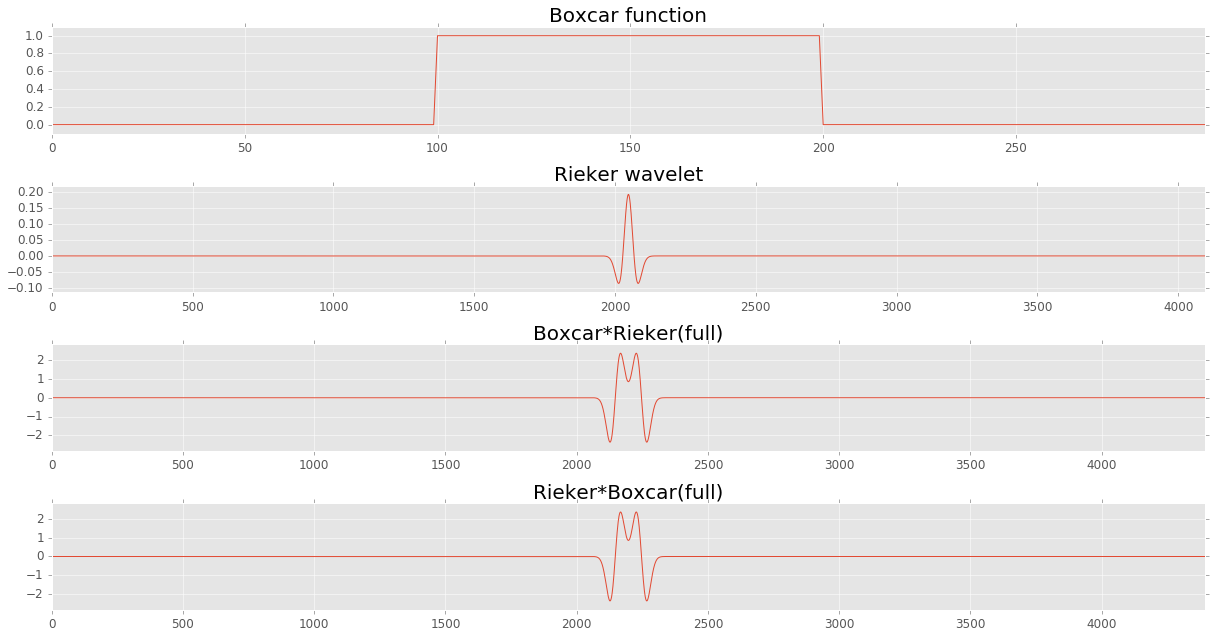

In [17]:
# Cell 3b - change one signal, convolve both signals + plotting

npts = 4096  
# make a box car function
sig = np.repeat([0., 1., 0.], 100)

# Rieker wavelet
rk = signal.ricker(npts, 20.0) 
# convolve the signals
filtered = signal.convolve(sig, rk, mode='full') 
filtered_2 = signal.convolve(rk, sig, mode='full') 
fig, (ax_orig, ax_win, ax_filt, ax_filt_2) = plt.subplots(4, 1)
ax_orig.plot(sig)
ax_orig.set_title('Boxcar function')
ax_orig.margins(0, 0.1)
ax_win.plot(rk)
ax_win.set_title('Rieker wavelet')
ax_win.margins(0, 0.1)
ax_filt.plot(filtered)
ax_filt.set_title('Boxcar*Rieker(full)')
ax_filt.margins(0, 0.1)
ax_filt_2.plot(filtered_2)
ax_filt_2.set_title('Rieker*Boxcar(full)')
ax_filt_2.margins(0, 0.1)
fig.tight_layout()
fig.show()


C:\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


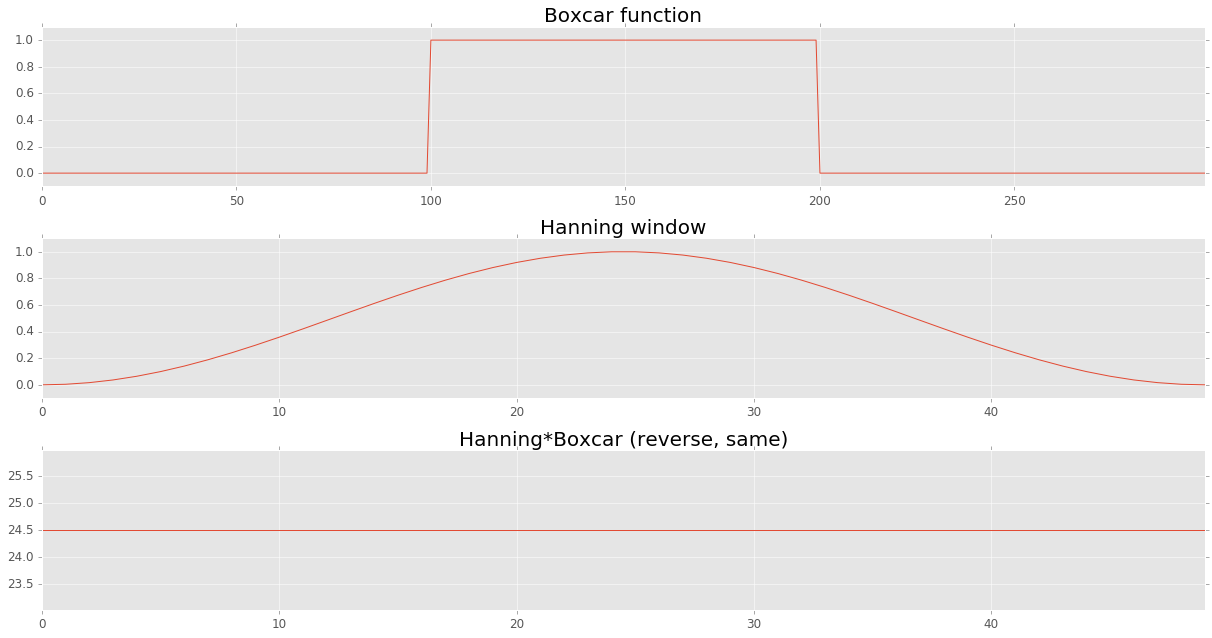

In [18]:
# Cell 3c - convolution in reverse order + plotting

# make a box car function
sig = np.repeat([0., 1., 0.], 100)
# make a Hann window 
win = signal.hann(50)

# convolve the signals

filtered = signal.convolve(win,sig, mode='same') 

# Plot the signals

fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1)
ax_orig.plot(sig)
ax_orig.set_title('Boxcar function')
ax_orig.margins(0, 0.1)
ax_win.plot(win)
ax_win.set_title('Hanning window')
ax_win.margins(0, 0.1)
ax_filt.plot(filtered)
ax_filt.set_title('Hanning*Boxcar (reverse, same)')
ax_filt.margins(0, 0.1)
fig.tight_layout()
fig.show()



C:\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


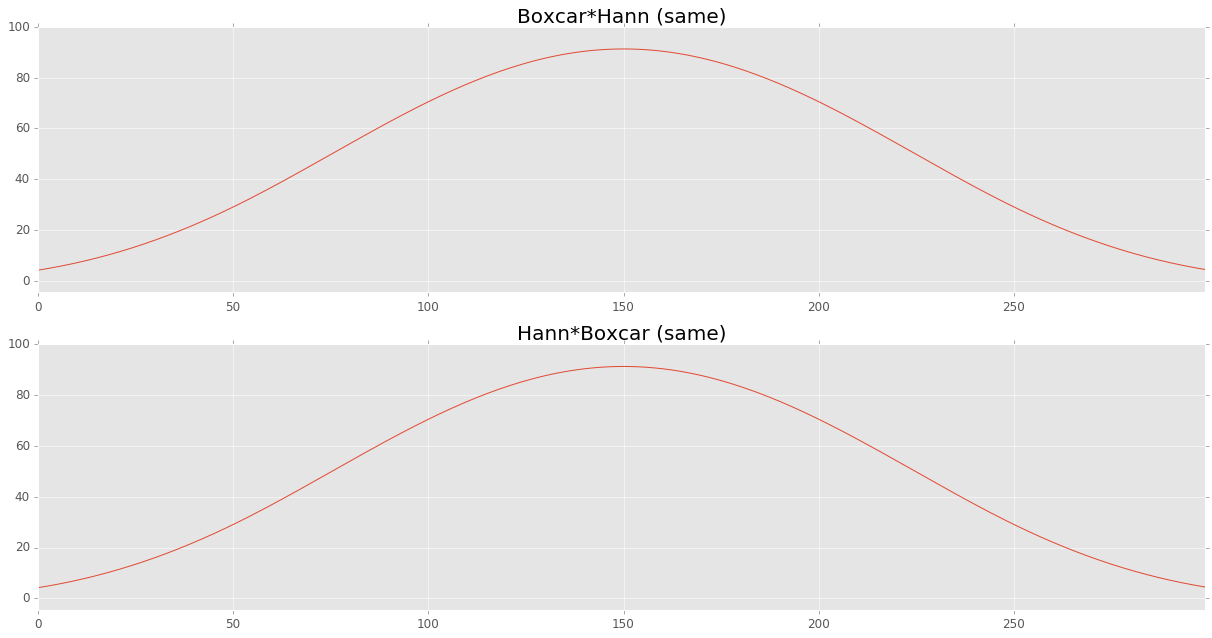

In [19]:
# Cell 3d - amend signals and convolve again (bonus)


# make a box car function
sig = np.repeat([0., 1., 0.], 100)
# make a Hann window 
win = signal.hann(300)
# convolve the signals

filtered = signal.convolve(win,sig, mode='same')
filtered_1 = signal.convolve(sig,win, mode='same') 

# plot of the signals

fig, (ax_win, ax_filt) = plt.subplots(2, 1)
ax_win.plot(filtered_1)
ax_win.set_title('Boxcar*Hann (same)')
ax_win.margins(0, 0.1)
ax_filt.plot(filtered)
ax_filt.set_title('Hann*Boxcar (same)')
ax_filt.margins(0, 0.1)
fig.tight_layout()
fig.show()






### Answer to exercise 3

###### a) What is a convolution? Convolution is closely connected to a special kind of system. Which one? Describe the connection.

Convolution is a mathematical way of combining two signals to form a third signal by multiplying their respective fourier transform signals, and then inverse fourier transforming the resultant. It gives the integral of the pointwise multiplication of the two functions as a function of the amount that one of the original functions is translated. 

Convolution is closely related to linear time invariant (LTI) systems. The input-output behavior of an LTI system can be characterized via its impulse response, and the output of an LTI system for any input signal x(t) can be expressed as the convolution of the input signal with the system's impulse respo

###### b)  Convolve the signals and plot them again. Are convolutions commutative?

Yes, convolution is just multiplication and is therefore commutative.

##### c) Are the results the same or different from cell 2a? Explain this result. Explain any inconsistencies.

The result is different from that of 3)a since on mode=same its limiting the output to the size of in1, which in this case is Hann, with a smaller size. Using arrays of different sizes,  in1 should be larger than in2.
We get a commutative output if we change the mode to full.

##### d)  Bonus (optional for extra points): Amend the signals so that convolving them in the reverse order gives the same result as convolving them in original order.

Increased the size of hanning to match that of boxcar, and plotted the convolution both ways to show commutativity.


__________________

## Exercise 4


In Cell 4a theoretical gravity data, modeled for the ringlaser location in Wettzell, are loaded. The data show a superposition of tidal effects due to different celestial bodies. Here is a short overview of the most important ones, sorted according the amplitude of their influence on Earth:
+ tides with a period of half a day from sun, moon, Mars, Jupiter, etc. ..., period: 0.5 day 
+ tides with a period of one day from sun, moon, Mars, Jupiter, etc. ..., period: 1 days
+ cycle of the orbit of the moon, period: 28 days
+ equinox - sun and moon passing the equator plane, period: 186 days (about every six months)
+ Chandler wobble (deviation of Earth's axis of rotation relative to the solid Earth), period: 433 days
+ effects due to further planets ....


a) In Cell 4b, calculate the spectrum of the data and plot it (as a log-log plot). Try to identify the different tidal effects and name the frequencies of their peak positions. Why is the peak for the Chandler wobble not really visible in the spectrogram? 
Hint: To calculate the spectrum, you can use the function [periodogram](http://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.signal.periodogram.html) of the scipy.signal package.

b) In Cell 4c, try to separate the tides with periods of half and full day from the other tidal effects by filtering. Which filter do you choose and why? Plot the filtered signal for about the first 28 days.  
Explain what happens behind the screens when applying a filter to data (in mathematical sense). 

c) Now, isolate the half day and full day tides separately from each other and from the rest of the data. Which filter do you choose this time and why? Plot the filtered signal for about the first 25 days on top of the filtered data from exercise 1b.  
How can a filter be defined, in terms of responses? There are mainly three different keywords. Describe them. Why do we need three instead of only one definition?


1 Trace(s) in Stream:
XX.WETZ..XZ | 2015-01-01T00:00:00.000000Z - 2015-12-30T23:00:00.000000Z | 3600.0 s, 8736 samples
         network: XX
         station: WETZ
        location: 
         channel: XZ
       starttime: 2015-01-01T00:00:00.000000Z
         endtime: 2015-12-30T23:00:00.000000Z
   sampling_rate: 0.0002777777777777778
           delta: 3600.0
            npts: 8736
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'byteorder': '>', 'filesize': 36864, 'number_of_records': 9, 'encoding': 'FLOAT32', 'record_length': 4096, 'dataquality': 'D'})


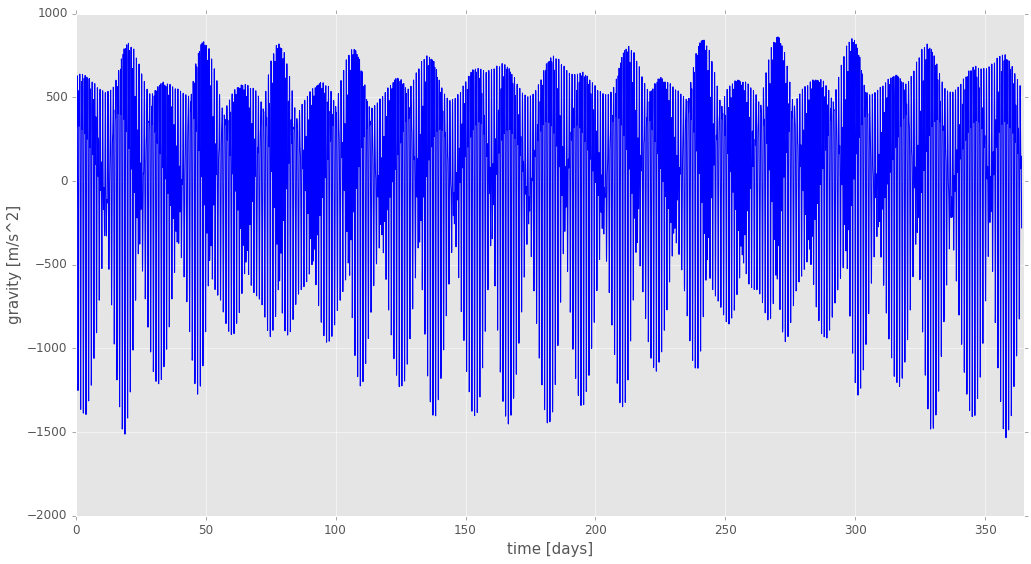

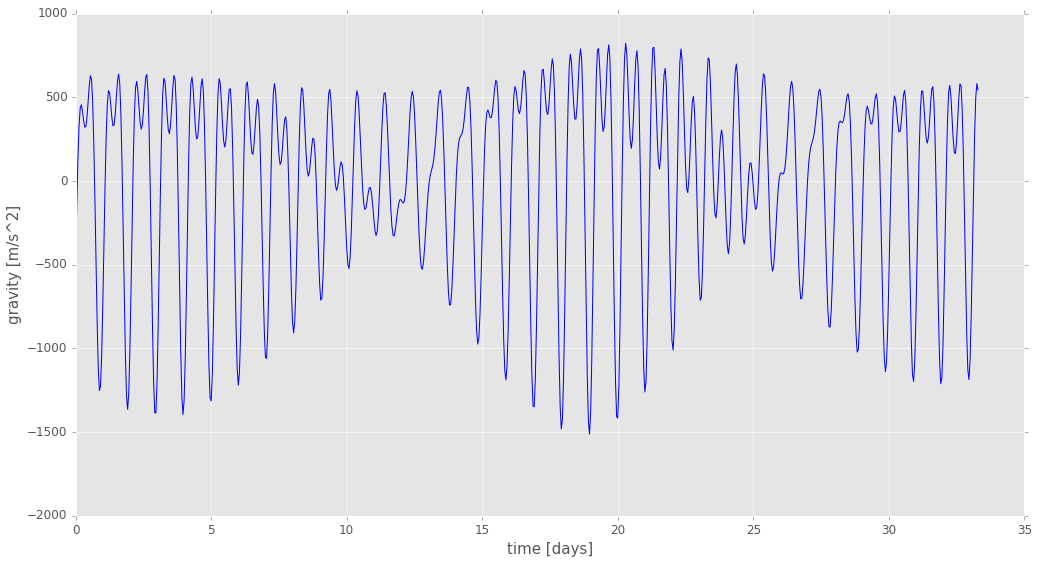

In [20]:
# Cell 4a - reading and plotting gravity data

# read in gravity data, modeled for Wettzell, Germany. Units is in nm/s^2 vertical acceleration. 
filename = 'data/gravity.dat'

# prepare to input data into obspy Stream
data = np.loadtxt(filename, dtype='float32', comments="#")
stats = {'network': 'XX', 'station': 'WETZ', 'location': '',
         'channel': 'XZ', 'npts': len(data), 'delta': 3600}

stats['starttime'] = UTCDateTime("2015,01,01,00,00,00")
s = Stream([Trace(data=data, header=stats)])

# write as MSEED file
s.write("gravity.mseed", format='MSEED')

# test that it worked, read stream from file and plot
st = read("gravity.mseed")
print(st)
print(st[0].stats)
#st.plot()

plt.plot(st[0].times()/(3600*24), st[0].data, color='b')
plt.xlim(0,365)
plt.xlabel("time [days]")
plt.ylabel("gravity [m/s^2]")
plt.show()

# zoom into first 35 days
plt.plot(st[0].times()[0:800]/(3600*24), st[0].data[0:800], color='b')
plt.xlabel("time [days]")
plt.ylabel("gravity [m/s^2]")
plt.show()

[2.3148148148148147e-05, 1.1574074074074073e-05, 4.133597883597884e-07, 6.222620469932298e-08]


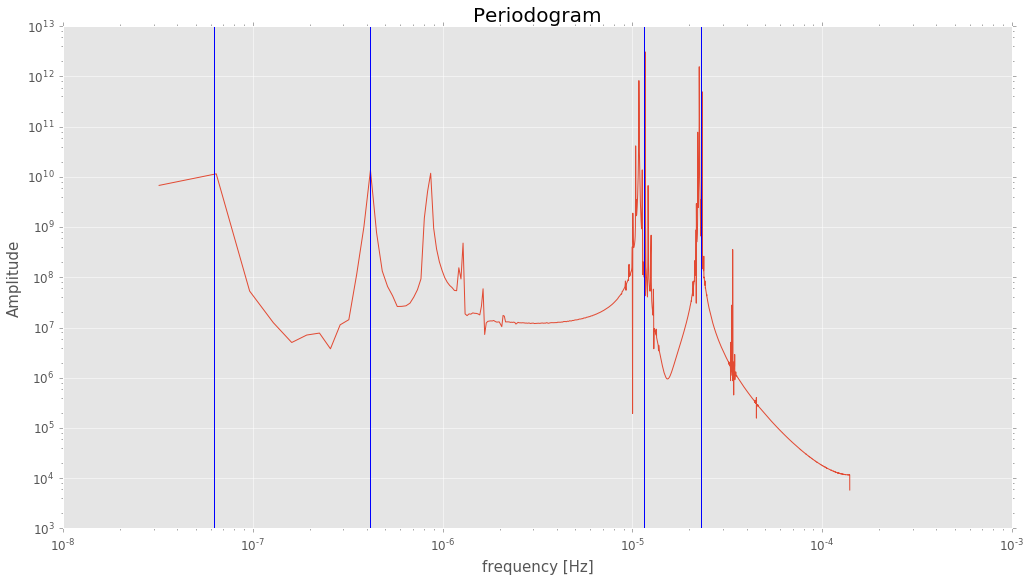

In [23]:
# Cell 4b - calculate spectrum
tides = [0.5,1,28,186]
fre = []

for i in tides:
    i = i* 24.*60.*60.
    y = 1./i
    fre.append(y)
print(fre)
    

#print([0,len(fre)])
fs = 0.00028
freq, Pow_spec = signal.periodogram(st[0], fs)
plt.loglog(freq, Pow_spec)

for i in fre:
    plt.axvline(i)
    
plt.title('Periodogram')
plt.xlabel('frequency [Hz]')
plt.ylabel('Amplitude')
plt.ylim([10**3,10**13])
plt.show()




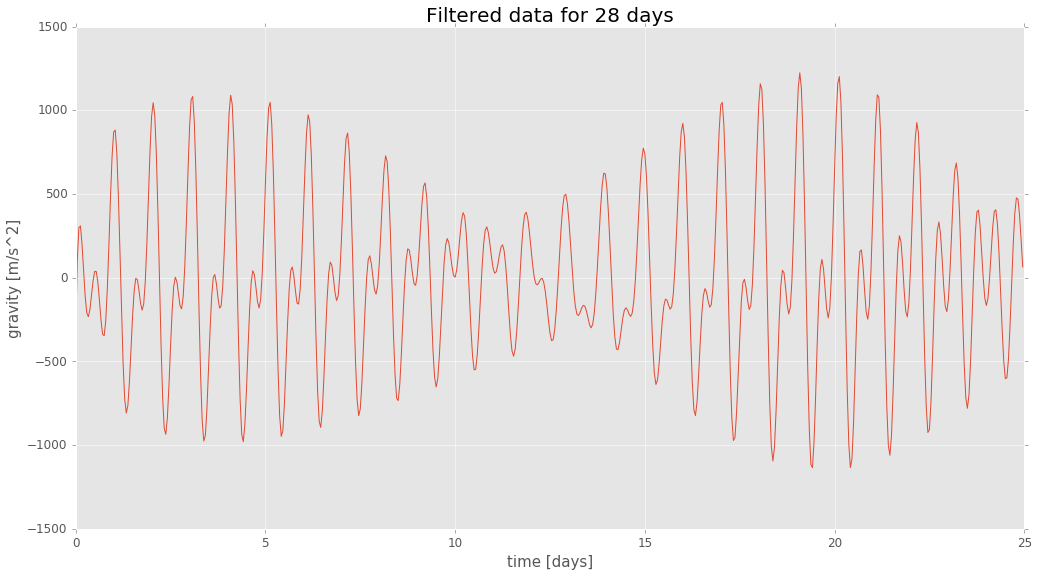

In [24]:
# Cell 4c - filtering the data

sfh = st.copy()
tfh = sfh[0]
ftfh = tfh.filter("highpass",freq=(0.9*fre[1]))
plt.plot(st[0].times()[0:600]/(3600*24),ftfh[0:600])
plt.title('Filtered data for 28 days')
plt.xlabel("time [days]")
plt.ylabel("gravity [m/s^2]")



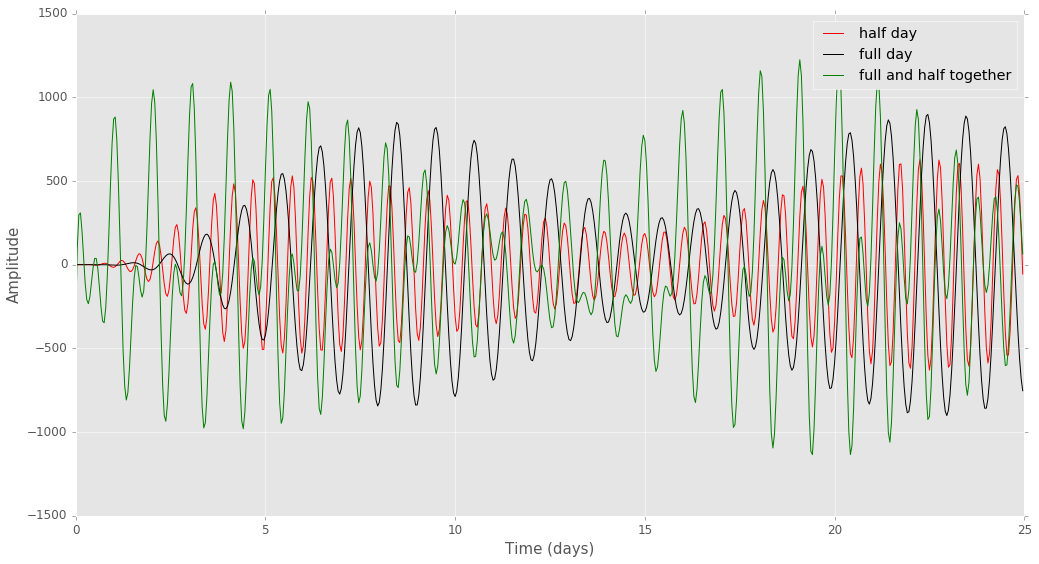

In [25]:
# Cell 4c - 

sh = st.copy()
sf = st.copy()

thh = sh[0]
tff = sf[0]

fthh = thh.filter("bandpass",freqmin=(0.9*(fre[0])) ,freqmax= (1.1*(fre[0])))
ftff = tff.filter("bandpass",freqmin=(0.9*(fre[1])) ,freqmax= (1.1*(fre[1])))


plt.plot(st[0].times()[0:600]/(3600*24),fthh[0:600],'r', label='half day')
plt.plot(st[0].times()[0:600]/(3600*24),ftff[0:600],'k', label='full day')
plt.plot(st[0].times()[0:600]/(3600*24),ftfh[0:600],'g', label='full and half together')
plt.ylabel('Amplitude')
plt.xlabel('Time (days)')
plt.legend()


### Answers to Question 4


##### a) Try to identify the different tidal effects and name the frequencies of their peak positions.

0.5 days :  Frequencies around 2.3x10^-5 Hz. Frequency peaks : between 2x10^-5 and 4x10^-5 Hz

1 day : Frequencies around 1.2x10^-5 Hz. The frequency peaks : between 10^-5 and 1.5x10^-5 Hz

28 days : Frequency around 4.1x10^-7 Hz. Frequency peaks : between 3x10^-7 and 9x10^-7 Hz

equinox period: 186 days Frequencies around 6.2x10^-8 Hz Frequency peaks: between 5x10^-8 and 7x10^-8 Hz

Chandler wobble period: 433 days Frequencies around 2.7x10^-8 Hz Frequency peaks : not visible


#####  Why is the peak for the Chandler wobble not really visible in the spectrogram?

We cannot see the peak of the chandler wobble because the chandler wobble has a period of 433 days (2.7x10^-8 Hz) which is higher than the period of our data which is 365 days (3.2x10^-8 Hz).


##### b)  Which filter do you choose this time and why? Explain what happens behind the screens when applying a filter to data (in mathematical sense)

 We choose a high pass filter at 10^-5 Hz because the frequencies of the tides that we wish to view are higher than 10^-5 Hz.

When a  filter is applied,  data is convoluted with the  chosen filter range. Here we chose a high pass filter at 10^-5 Hz, thus in the frequency domain all the data with frequency values above 10^-5 Hz gets multiplied by 1, while the data with frequency values below 10^-5 Hz gets multiplied by 0. This the only visible data is above the 10^-5 Hz point.

##### Which filter do you choose this time and why?

For the half day tides the chosen filter is a high pass filter at 2.2x10^-5 since the frequency of the half day tides is about 2.3x10^-5.

For the full day tides the chosen filter is a band pass filter between 2.2x10^-5 since the frequency of the half day tides is about 2.3x10^-5.

##### How can a filter be defined, in terms of responses? There are mainly three different keywords. Describe them.

A filter is defined as the frequency response function which is the Fourier transform of the impulse response function, defined as the response of a filter to an impulsive (delta function) input signal.
The frequency response is our filter in the frequency domain.
The fourier transform is the operation to go from the time to the frequency domain.
The impulse response is our filter in the time domain.

#### Why do we need three instead of only one definition.

We need three and not one, since together they better describe all the facets/properties of a filter across both time and frequency domains. The process of filtering requires convolution in the time domain (which is very time consuming to perform) thus we need to transform our impulse response (using the fourier transform) into the frequency domain where convolution becomes simple multiplication, and once that is done we can use the inverse fourier transform to return our data to the time domain.

___________________

## Exercise 5

In this question we are going to use a cross correlation technique to make a differential pick time. You are provided with two signals in the data directory: 

`data/seismogram_1.MSEED` <br>
`data/seismogram_2.MSEED`

seismogram_2.MSEED is noisy, and arrives later than seismogram_1.MSEED. We will use a cross-correlation with the better seismogram to make a more accurate pick of the arrival time on the noisy seismogram. 

For this question you should use the obspy function xcorr_pick_correction(). This is well documentated, and has good default plotting options. 

You are given these initial pick times. <br>
t1 = UTCDateTime(0.335)<br>
t2 = UTCDateTime(0.55)

a) Read in the seismograms in Cell 5a. Use the function [xcorr_pick_correction](https://docs.obspy.org/packages/autogen/obspy.signal.cross_correlation.xcorr_pick_correction.html) to create a cross correlation. There is no need to filter the seismograms.  <br>
Plot the cross correlation. Display the Time correlation and Correlation coefficient.

b) What was the length of the time window you cross-correlated over? Why is this a good choice?  

c) Calculate the corrected differential pick time in Cell 5b. This is the time lag between the first arrival on seismogram 1 and on seismogram 2.

d) Write a short paragraph on what has been done here, and why it could be useful. 


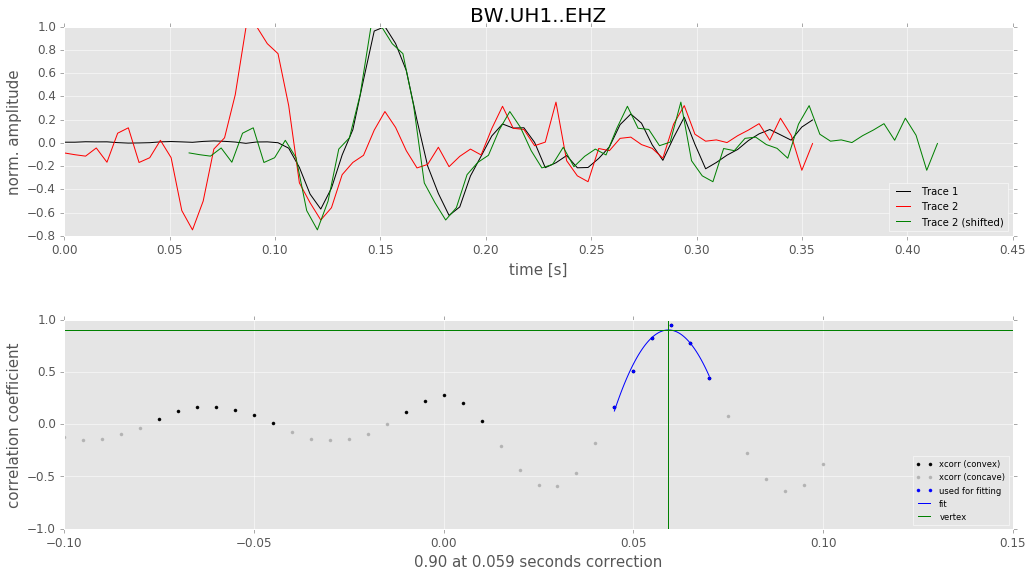

No preprocessing:
  Time correction for pick 2: -0.059247
  Correlation coefficient: 0.90
1 Trace(s) in Stream:
BW.UH1..EHZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.845000Z | 200.0 Hz, 170 samples 
 1 Trace(s) in Stream:
BW.UH1..EHZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.845000Z | 200.0 Hz, 170 samples


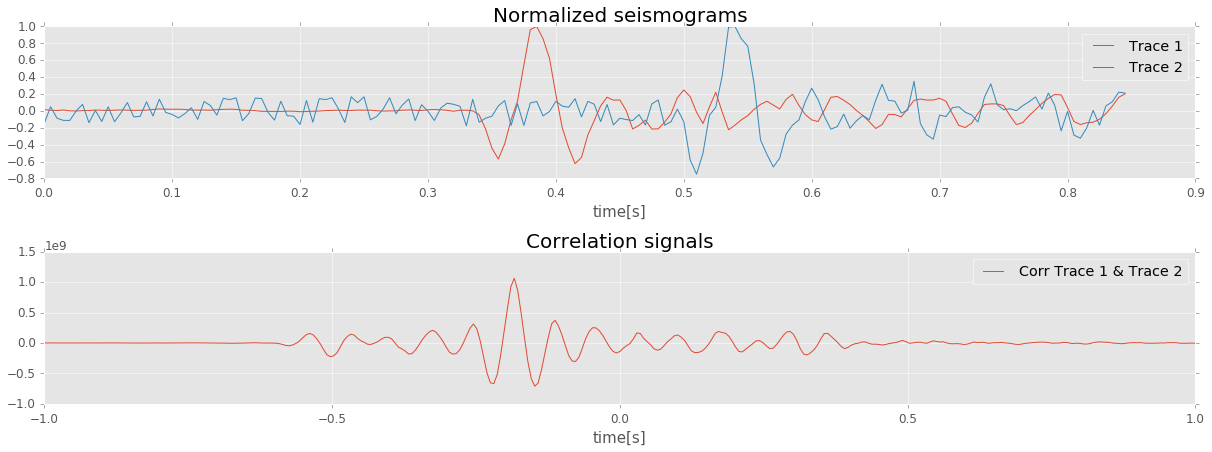

Lag trace 1 and trace 2: -0.183432 seconds
Correlation coefficient trace 1 and trace 2: -0.113265 



In [26]:
# Cell 5a - crosscorrelation


# code modified from "https://docs.obspy.org/packages/autogen/obspy.signal.cross_correlation.xcorr_pick_correction.html"


from __future__ import print_function
import obspy
from obspy.signal.cross_correlation import xcorr_pick_correction

st1 = obspy.read('data/seismogram_1.MSEED')
st2 = obspy.read('data/seismogram_2.MSEED')
# select the single traces to use in correlation.
# to avoid artifacts from preprocessing there should be some data left and
# right of the short time window actually used in the correlation.
tr1 = st1.select(component="Z")[0]
tr2 = st2.select(component="Z")[0]
# these are the original pick times set during routine analysis
t1 = obspy.UTCDateTime(0.335) # pick 1
t2 = obspy.UTCDateTime(0.55)  # pick 2

# estimate the time correction for pick 2 without any preprocessing and open
# a plot window to visually validate the results
dt, coeff = xcorr_pick_correction(t1, tr1, t2, tr2, 0.05, 0.2, 0.1, plot=True)
print("No preprocessing:")
print("  Time correction for pick 2: %.6f" % dt)
print("  Correlation coefficient: %.2f" % coeff)

# print the correlation function
print(st1, '\n', st2)

xcorr1 = np.correlate(tr1.data, tr2.data, mode='full')
peak_index1 = abs(xcorr1).argmax()
cc1 = np.corrcoef(tr1.data, tr2.data)[0,1]

cc_t = np.linspace(-1.0, 1.0, len(xcorr1))

plt.subplot(3,1,1)
plt.title('Normalized seismograms')
plt.plot(tr1.times(), tr1.data/abs(tr1.max()), label='Trace 1')
plt.plot(tr2.times(), tr2.data/abs(tr2.max()), label='Trace 2')
plt.legend()

plt.xlabel('time[s]')

plt.subplot(3,1,2)
plt.title('Correlation signals')
plt.plot(cc_t, xcorr1, label='Corr Trace 1 & Trace 2')

plt.legend()
plt.xlabel('time[s]')

plt.tight_layout() 
plt.show()

print("Lag trace 1 and trace 2: %f seconds" % cc_t[peak_index1])
print("Correlation coefficient trace 1 and trace 2: %f \n" % cc1)





c:\anaconda3\lib\site-packages\obspy-1.0.1-py3.5-win-amd64.egg\obspy\signal\cross_correlation.py:317: UserWarning: Artifacts from signal processing possible. Trace 0 should have more additional data at the start.
  warnings.warn(msg)
c:\anaconda3\lib\site-packages\obspy-1.0.1-py3.5-win-amd64.egg\obspy\signal\cross_correlation.py:321: UserWarning: Artifacts from signal processing possible. Trace 0 should have more additional data at the end.
  warnings.warn(msg)
c:\anaconda3\lib\site-packages\obspy-1.0.1-py3.5-win-amd64.egg\obspy\signal\cross_correlation.py:321: UserWarning: Artifacts from signal processing possible. Trace 1 should have more additional data at the end.
  warnings.warn(msg)


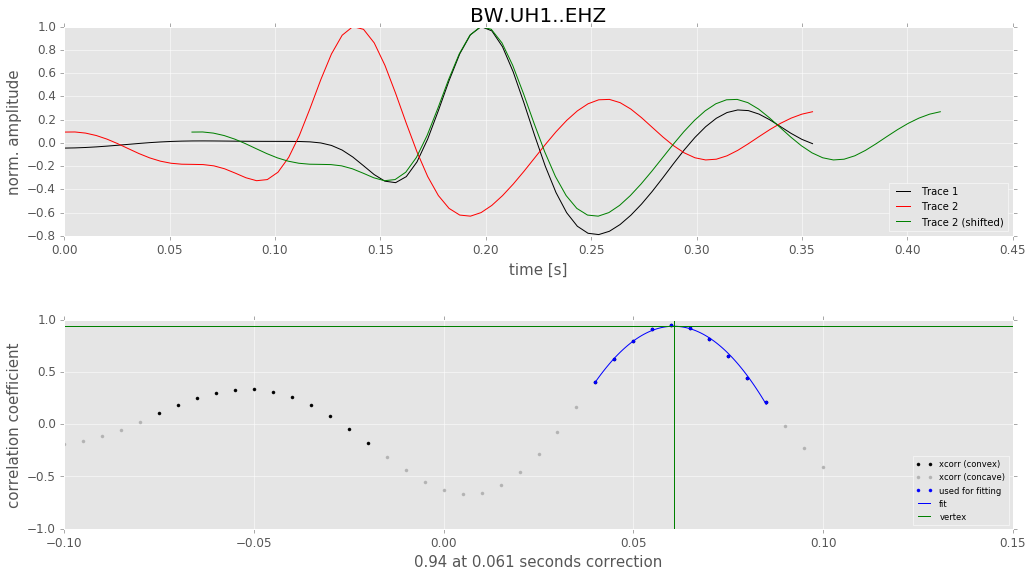

Bandpass prefiltering:
  Time correction for pick 2: -0.060608
  Correlation coefficient: 0.94


In [28]:
# Cell 5b - differential pick times

#code modified from "https://docs.obspy.org/packages/autogen/obspy.signal.cross_correlation.xcorr_pick_correction.html"
# apply bandpass
dt, coeff = xcorr_pick_correction(t1, tr1, t2, tr2, 0.05, 0.2, 0.1, plot=True,
                                  filter="bandpass",
                                  filter_options={'freqmin': 1, 'freqmax': 10})
print("Bandpass prefiltering:")
print("  Time correction for pick 2: %.6f" % dt)
print("  Correlation coefficient: %.2f" % coeff)


________________

## Final bonus question

Between sound, tidal, and seismic/seismological data, what do you prefer to work on considering computational effort? Explain why.

### Answer to bonus question

Taking into accout the computational costs, it seems more preferable to work with tidal data compared with seismic data and sound data.This is because higher frequency means heavier their computational costs. 
For example, considering sound data, the maximum frequency for human ear has a frequency of around 2x10^4 Hz which means the Nyquist frequency is around 4x10^4 Hz. 
For Tidal data, the maximum frequency is around 2x10^-5 Hz which means the Nyquist frequency is around 4x10^-5 Hz.
For seismic/seismological data, the maximum frequency contained is around 10^2 Hz i.e. in reflection seismology, which means the Nyquist frequency would be around 2x10^2 Hz, or 10^-2 to 10^0 Hz for global seismology. Thus,  the higher the nyquist frequency the higher the computational costs. Tidal data has the lowest Nyquist frequency meaning it has the lowest computational costs followed by seismic/seismological data while sound data has the highest computational effort.